# Estimate of the catalog completeness within the sky localizations of gravitational-wave events.

The code analyzes the gravitational-wave sky localization observed during the O1, O2 and O3a runs from the LIGO and Virgo Collaborations. In particular, we estimate the catalog completeness within the credible volume provided in the final skymaps issued in the first and second GWTC (Gravitational-Wave Transient Catalog).

In order to get a more complete picture, we identify the intersection area with the Galactic dust extinction and what percentage of the gravitational-wave sky location falls in it. 

A summary table is also provided in which a "completeness coefficient" is determined for each gravitational-wave sky localization.


*Maria Lisa Brozzetti*, <marialisa.brozzetti@studenti.unipg.it> 

*Giuseppe Greco*, <giuseppe.greco@pg.infn.it> 

*Gergely Dalya*, <gergely.dalya@ugent.be>


In [1]:
import os
from urllib.parse import urlparse

import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
 
import pandas as pd

from astroquery.vizier import VizierClass 

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord 
from astropy.utils.data import download_file

from ligo.skymap.io import read_sky_map
from ligo.skymap.postprocess import crossmatch

import healpy as hp 

import mocpy 
from mocpy import MOC, World2ScreenMPL

import scipy  
from scipy import interpolate
from scipy.special import gammainc, gammaincc, gamma

## Query Catalogues from VizieR

**Vizier** provides the most complete library of published astronomical catalogues --tables and associated data- with verified and enriched data, accessible through multiple interfaces. Query tools allow the user to select relevant data tables and to extract and format records that match certain criteria. More than *21,000 catalogues* are currently available.

For more information http://vizier.u-strasbg.fr

In [2]:
#%time
#vizier = VizierClass(row_limit=-1, columns=['z','GWGC', 'Bmag', 'e_Bmag', '_RAJ2000', '_DEJ2000', 'Dist', 'e_Dist'])
#cat, = vizier.get_catalogs('VII/281/glade2')
#coordinates = SkyCoord(cat['_RAJ2000'], cat['_DEJ2000'], cat['Dist'])

In [2]:
import pickle

try:
    print("Vizier files are present in the working folder!")
    print("Reading vizier.pkl...")
    with open('vizier.pkl', 'rb') as fh:
        vizier = pickle.load(fh)
        
    print("Reading cat.pkl...")
    with open('cat.pkl', 'rb') as fh:
        cat = pickle.load(fh)
    
    print("Reading coordinates.pkl...")
    with open('coordinates.pkl', 'rb') as fh:
        coordinates = pickle.load(fh)
except:
    print("Vizier files need to be regenerated!")
    vizier = VizierClass(row_limit=-1, 
                         columns=['z','GWGC', 'Bmag', 'e_Bmag', 
                                  '_RAJ2000', '_DEJ2000', 'Dist', 'e_Dist'])

    print("Saving vizier.pkl...")
    
    with open('vizier.pkl', 'wb') as fh:
        pickle.dump(vizier, fh)
        
    cat, = vizier.get_catalogs('VII/281/glade2')
    print("Saving cat.pkl...")

    with open('cat.pkl', 'wb') as fh:
        pickle.dump(cat, fh)
        
    coordinates = SkyCoord(cat['_RAJ2000'], cat['_DEJ2000'], cat['Dist'])
    print("Saving coordinates.pkl...")
    
    with open('coordinates.pkl', 'wb') as fh:
        pickle.dump(coordinates, fh)

Vizier files are present in the working folder!
Reading vizier.pkl...
Reading cat.pkl...
Reading coordinates.pkl...


## Reading Files and Creating directory

In [3]:
def create_directories(skymap_url): 
    """
    Create folder in which save documents for the first two observational run"""

    # Get superevent from URL
    superevent = urlparse(skymap_url).path.rsplit("/")[-1]
    superevent
    name= urlparse(superevent).path.rsplit("_")[0]

    # Directory
    directory = name

    # Parent Directory path
    parent_dir = !pwd
    parent_dir = parent_dir[0]
    print(parent_dir)

    # Path
    path = os.path.join(parent_dir, directory)
    try:
        os.mkdir(path) #comment if the directory already exists
        print("Directory '% s' created" % directory)
    except:
        print("Directory '% s' already exists!" % directory)
    
    return path, name

### Defining functions  for the analysis

In [4]:
def credible_volume(url_skymap, credible_level=0.9):
    '''
    Return the credible volume within the 3D credible region of the probabilities 
    specified by the credible_level argument.
    '''
    
    skymap = read_sky_map(url_skymap, moc=True)
    
    crossmatch_result = crossmatch(skymap, contours=(credible_level,))
    cr_volume, = crossmatch_result.contour_vols

    return cr_volume

In [5]:
def luminosity_from_schechter_function(volume):
    '''
    Luminosity estimation with the Schechter Function.
    '''

    h = 0.7 # H_0/100
    Lb0 = 2.16e33 # solar luminosity in B-band
    l_csill = 1.2*10**10 * h**(-2) * Lb0
    fi_csill = 1.6*pow(10,-2)*pow(h,3) 
    
    lum =  gammaincc(0.93,0.0)*gamma(0.93) * 0.7 * fi_csill * l_csill * volume
    
    return lum 

In [6]:
def Schechter(lum, volume, h=0.7, phi=(1.6e-2)*(0.7**3) , a=-1.07, alfa=-0.07):
    """
    The Schechter function with fixed parameters.
    """
    
    sigma = phi * np.power(lum, alfa) * np.power(np.e,-lum) * volume * (0.7*0.7*0.7)
    
    return sigma 

In [8]:
def coeff_completeness(lum_tot, volume):
    '''
    Coefficient to evaluate the completeness of the catalogue in the gravitational-wave credible volume.
    '''

    coeff=lum_tot*100/luminosity_from_schechter_function(volume)
    
    return coeff

In [7]:
def completeness(url_1, destination_path):
    """
    Catalog completeness for the events observed in the observational runs: O1, O2 and O3a.    
    """
   
    Lsun=2.16e33 # luminosity of Sun erg/sec 
    Msun=5.48 #   absolute magnitude
    h=0.7
    
    skymap= read_sky_map(url_1,moc=True)
    crossmatch_result = crossmatch(skymap, contours=(0.9,))

    vol = credible_volume(url_1)
        
    result=crossmatch(skymap,coordinates)

    table=cat[result.searched_prob_vol < 0.9]
    table['dP-dV']=result.probdensity_vol[result.searched_prob_vol < 0.9].round(10)
        
    # Creating two columns
    Bmag1=table['Bmag']
    Dist1=table['Dist'] 
        
    # Init. values and lists
    no_bmag=0 
    no_dist=0 
    Bmag=[] 
    indici=[] 
    Dist=[]

    for i in range(len(Bmag1)):
        if type(Bmag1[i])==np.ma.core.MaskedConstant: # mask
            no_bmag+=1 
        else: 
            if type(Dist1[i])==np.ma.core.MaskedConstant: 
                no_dist+=1 
            else: 
                Bmag.append(Bmag1[i]) 
                indici.append(i) 
                Dist.append(Dist1[i])
    d=np.array(Dist)
    m=np.array(Bmag)
        
    # Parameters
    M=m-5*np.log10(d*(10**5))

    L=Lsun*10**((Msun-M)/2.5)

    Lb0=2.16e33
    Lb=1.2e10*(h**(-2))*Lb0

    xtot=L/Lb
    m_th=round(sum(m)/len(m),2)

    # Reading useful skymap metadata
    skymap, meta = read_sky_map(url_1)
    distmean=meta['distmean']
    diststd=meta['diststd']
    
    R1=distmean-3*diststd
    R2=distmean+3*diststd

    x=[]
    y=[]

    for i in range(len(xtot)): 
        if d[i]>=R1:
            if d[i]<=R2:
                x.append(xtot[i])
                y.append(L[i]) 
    lum_tot=sum(y)

    t=np.arange(0.0005, 10, 0.0001)
       
    xarrk=np.logspace(-3,1,10)
    sums=[]
        
    # Calculate the number of galaxies in a range
    for i in range(len(xarrk)-1):
        Min=xarrk[i]
        Max=xarrk[i+1]
        somma=0
        for j in range(len(x)):
            if x[j]>=Min:
                if x[j]<=Max:
                    somma+=1
        if somma==0:
            if i==0:
                somma=0.1
                sums.append(somma)
            else:
                sums.append(sums[i-1])
        else:
            sums.append(somma)
    xarrk_1=xarrk[1:]

    # Plotting
    fig, ax = plt.subplots(dpi=100)
    textstr = '\n'.join((r'$d_L$ =%.2f Mpc' % (distmean, ), r'$\sigma$ =%.2f Mpc' % (diststd, )))
    
    plt.plot(np.log10(t), [np.log10(y) for y in Schechter(t,vol)], 'r--', label='Schechter func.')
    plt.plot(np.log10(xarrk_1), np.log10(sums), 'b-', label='luminosity distrib.')
    plt.title('Completeness for the event '+ name)
    plt.legend(loc='lower center')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    
    plt.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=10,
    verticalalignment='top', bbox=props)
    
    plt.xlabel('log($L_b/L_b*$)')
    plt.ylabel('log(N)')
    plt.savefig(destination_path +'/'+'completeness event_'+ name+'.png', dpi=120)
    plt.show()
        
    return (xarrk_1, sums, R1, R2, m_th, round(distmean), name, vol, lum_tot)

In [9]:
def missed_galaxies(xarrk_1, sums, vol, path, filename): 
    '''Counting number of galaxies missed as a function of B-band Luminosity
    '''
    
    t=np.arange(0.0005, 10, 0.0001)
    f1=interpolate.interp1d(xarrk_1, sums) # blue
    f2=interpolate.interp1d(t,Schechter(t,vol)) # red
    
    # Define coefficient.
    c=[]
    a_app=[]
    t_app=[]

    for i in range(len(xarrk_1)):
        a_1=f1(xarrk_1[i]) 
   
        a_app.append(a_1)
        if i<= 100:
            t_1=f2(t[i])
            t_app.append(t_1)
            c.append(t_1-a_1)
        else:
            break
    for i in range(len(t)):
        if i<= 100:
            t_1=f2(t[i])
            t_app.append(t_1)
        else:
            break
    c=[]

    for j in range(len(a_app)):
        c_3 = t_app[j] - a_app[j]
        c.append(c_3)

    fig= plt.figure(dpi=120)
    plt.semilogx(xarrk_1, c)
    plt.xlabel('log($L_B/L_B*$)')
    plt.ylabel('N. gal missed')
    plt.title('Missed galaxies as a function of B-band Luminosity: '+filename, size=7)

    plt.savefig(path +'/'+'missed galaxies_'+filename+'.jpg',bbox_inches='tight',dpi=(120),)

In [10]:
# Init. to create a summary table
name_table=[]
dst_table=[]
m_table=[]
coeff_table=[]
int_perc_table=[]
volumes_table=[]
coef_norm=[]

In [11]:
coef_norm=[]

In [12]:
def normalization(coef_table):
    '''Normalisation of the coefficient of completeness between 0 and 1'''

    major=max(coef_table)
    for i in range(len(coef_table)):
        x=0
        if coef_table[i]==0:
            coef_table[i]=0
        else:
            coef_table[i]=(coef_table[i]/major)
        
        x=coef_table[i]
        coef_norm.append(x)

    return coef_norm

# Table generation

In [13]:
import copy

def summary_table(name_table, dst_table, m_table, int_perc_table, volumes_table, coef_norm):
    '''
    Creation of a summary_table. 
    '''

    headers = ['N°', "GW event", 'Dist [Mpc]', '$m_{th}$[magn]',
               'Intersection[%] ','V[$Mpc^{3}$]','c [%]']  
    
    GW_event=name_table
    num_event=range(1, len(GW_event)+1)
    distmean =dst_table
    magnmean= m_table
    c = coef_norm
    area = int_perc_table
    volumes = []
    
    for i in range(len(volumes_table)):
        if volumes_table[i]>=10**3:
            volumes.append(format(volumes_table[i],'.1E'))
        else:
            volumes.append(int(volumes_table[i]))
    
    table = zip(num_event,GW_event, distmean, magnmean, area, volumes, c)
    
    print(tabulate(copy.deepcopy(table), headers=headers,  tablefmt='latex'))

    with open('table_final.txt', 'w') as f:
        f.write(tabulate(copy.deepcopy(table), headers=headers, tablefmt='latex', showindex=True))
        f.flush()

### Galactic Dust Reddening and Extinction

In [14]:
# Read Galactic Dust Reddening from CADE data server
ext_map,h = hp.read_map('http://cade.irap.omp.eu/documents/Ancillary/EBV_SFD98/EBV_SFD98_1_512.fits', 
                        nest=True, h=True)

# Set pixel range from 0.5 up to the highest value.
index = np.nonzero((ext_map >= 0.5)& (ext_map <= 1000))

# set MOC order
depth=9

# Create and write a MOC from Galactic Dust Reddening
moc_low_ext = mocpy.MOC.from_healpix_cells(index[0],  
                                           np.ones_like(index[0])*depth)

moc_low_ext.write('ext_map.fits', overwrite=True)
ext_map = MOC.from_fits('ext_map.fits')

/opt/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/opt/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/opt/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [21]:
def intersection_credible_region_galactic_dust(skymap_url, ext_map, path):
    '''
    Calculation and plot of the intersection region between the gravitational-wave sky localizations 
    and the Galactic Dust Reddening and Extinction (>= 0.5).
    '''
    
    skymap = download_file('file:'+skymap_url)
    
    fig = plt.figure(111, figsize=(20, 10))
    fig= plt.figure(dpi=120)
    color_dust = 'red'
    fig = plt.figure(111, figsize=(20, 10))
    fig= plt.figure(dpi=120)
    with World2ScreenMPL(fig, 
                fov=360*u.deg,
                center=SkyCoord(180, 0, unit='deg', frame='icrs'),
                coordsys="icrs",
                rotation=Angle(0, u.degree),
                projection="MOLL") as wcs:
            ax = fig.add_subplot(1, 1, 1, projection=wcs)
          
            # Plot moc dust 
            moc_low_ext.fill(ax=ax, wcs=wcs, alpha=1, linewidth=0, fill=True, color=color_dust, 
                     label='Galactic Dust Reddening and Extinction >= 0.5')
            moc_low_ext.border(ax=ax, wcs=wcs, alpha=0.8, color=color_dust)
        
            # Plot credible regions
            credible_region = MOC.from_multiordermap_fits_file(skymap, cumul_to=0.9)
        

            credible_region.border(ax=ax, wcs=wcs, alpha=0.8, color='green')
            area_tot_moc=credible_region.sky_fraction*41253
            area_tot_moc=round(area_tot_moc,2)
            credible_region.fill(ax=ax, wcs=wcs, alpha=0.5,linewidth=0, fill=True, color='green', 
                                 label='90% Area: '+str(area_tot_moc)+ ' sq. deg. ')
        
            # Measure intersection with dust region
            intersection = credible_region.intersection(ext_map)
            intersection_area = intersection.sky_fraction*41253
            intersection_area = round(intersection_area,2)
            
            perc_int=round(100*intersection_area/area_tot_moc,2)
            
            ax.legend()            
            info_intersection_dust = ("The intersection area with the Galactic Dust Reddening is " \
                                      + str(intersection_area)+ " sq. deg. " +  " - "+ str(perc_int)+ \
                                      "% of the plotted credible region area")

            plt.title(name+': Sky Localization', fontsize=25)
            plt.grid(color="black", linestyle="dotted")
            ax.text(90,10, info_intersection_dust, fontsize=15)

            # Saving plot
            plt.savefig(path+'/'+'intersection'+'.png', bbox_inches='tight',
                        dpi=(120),transparent=True) 

    return perc_int         

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Running analysis

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
unknown skymap: .DS_Store
unknown skymap: .ipynb_checkpoints
url: ///Users/mlisa/Desktop/tesi_completezza_v8/run_o1_o2_o3/GW150914_multiorder.fits
/Users/mlisa/Desktop/tesi_completezza_v8
Directory 'GW150914' already exists!
name: GW150914
path: /Users/mlisa/Desktop/tesi_completezza_v8/GW150914


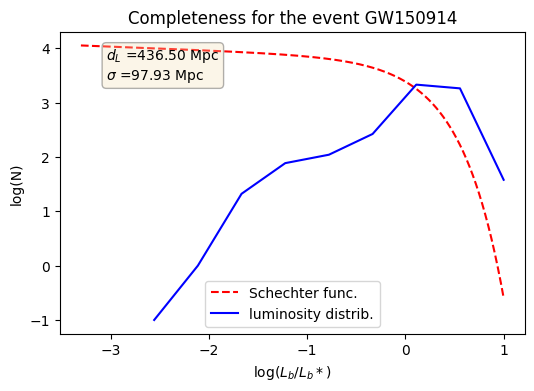

url: ///Users/mlisa/Desktop/tesi_completezza_v8/run_o1_o2_o3/GW151012_multiorder.fits
/Users/mlisa/Desktop/tesi_completezza_v8
Directory 'GW151012' already exists!
name: GW151012
path: /Users/mlisa/Desktop/tesi_completezza_v8/GW151012


<Figure size 720x480 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

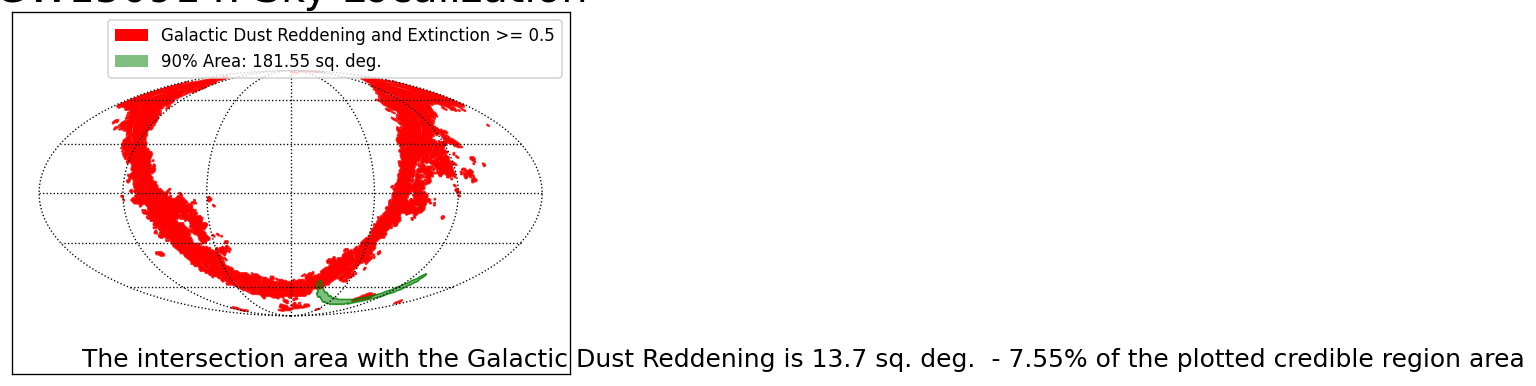

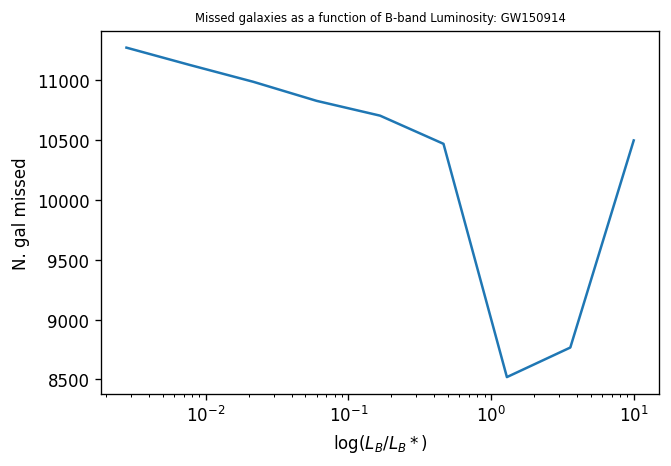

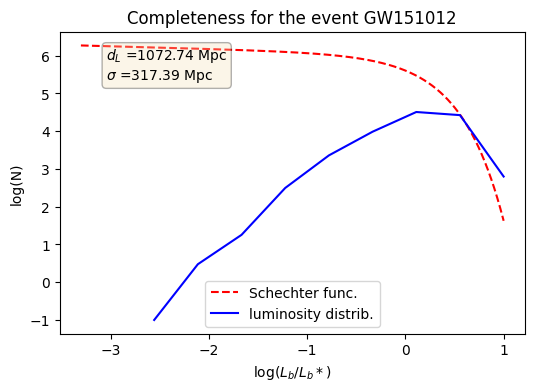

url: ///Users/mlisa/Desktop/tesi_completezza_v8/run_o1_o2_o3/GW151226_multiorder.fits
/Users/mlisa/Desktop/tesi_completezza_v8
Directory 'GW151226' already exists!
name: GW151226
path: /Users/mlisa/Desktop/tesi_completezza_v8/GW151226


<Figure size 720x480 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

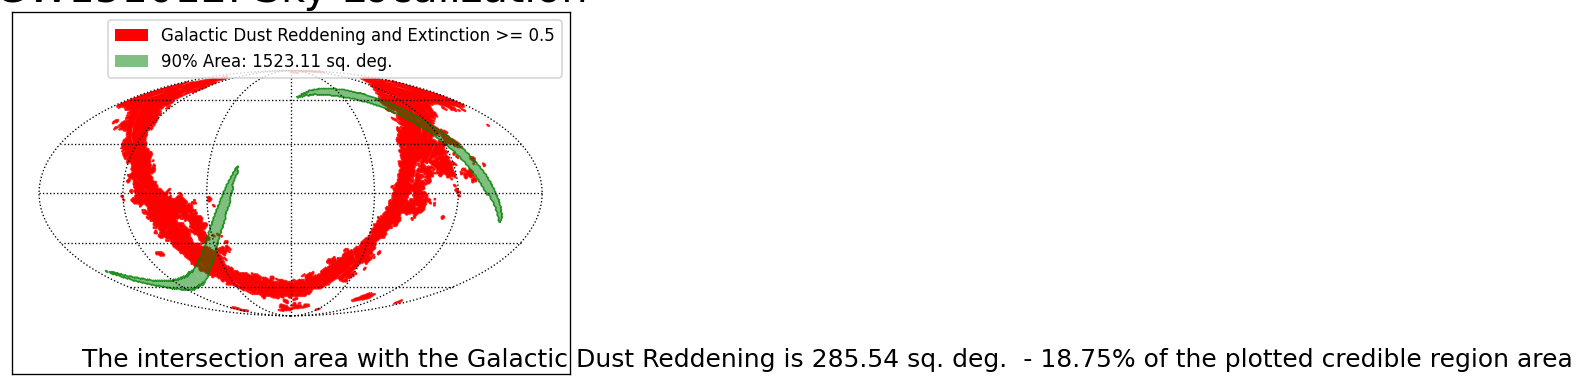

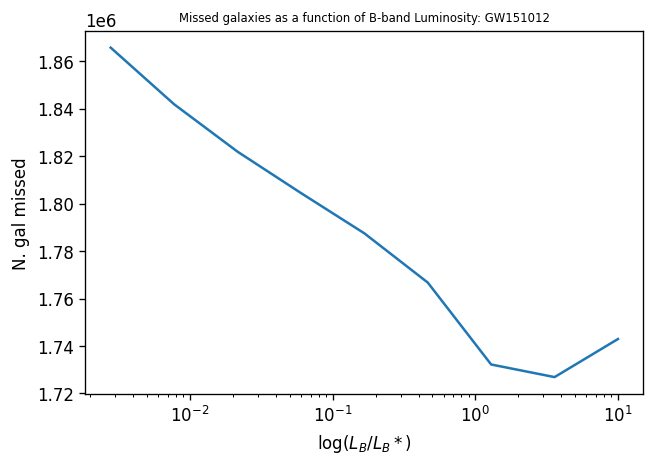

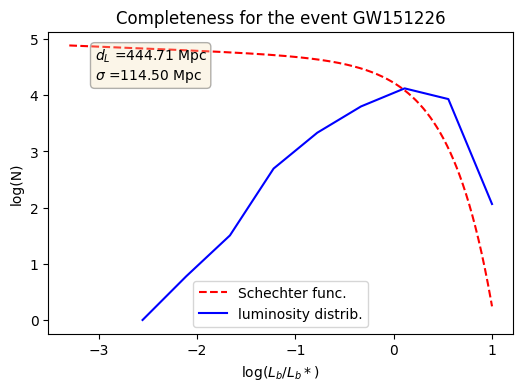

url: ///Users/mlisa/Desktop/tesi_completezza_v8/run_o1_o2_o3/GW170104_multiorder.fits
/Users/mlisa/Desktop/tesi_completezza_v8
Directory 'GW170104' already exists!
name: GW170104
path: /Users/mlisa/Desktop/tesi_completezza_v8/GW170104


<Figure size 720x480 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

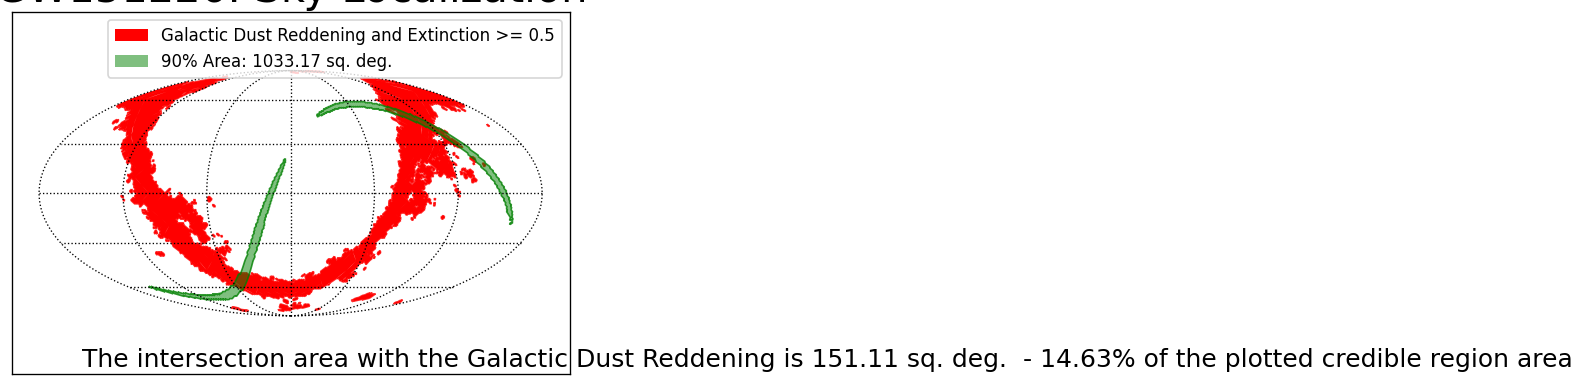

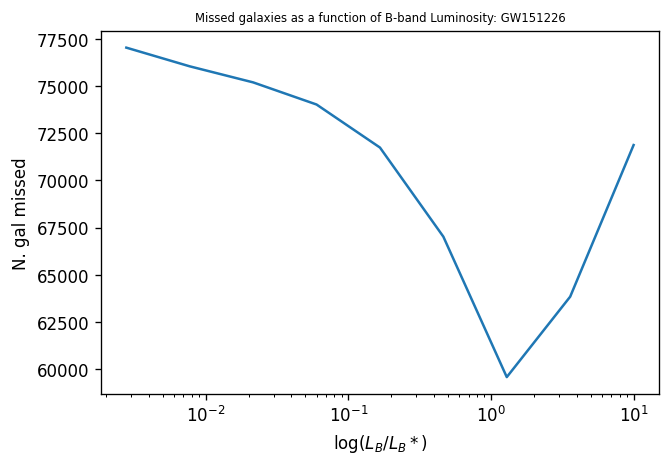

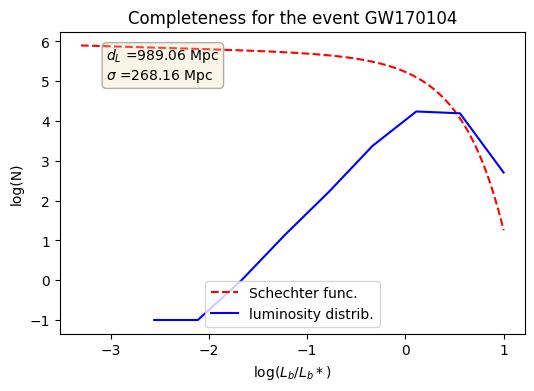

url: ///Users/mlisa/Desktop/tesi_completezza_v8/run_o1_o2_o3/GW170608_multiorder.fits
/Users/mlisa/Desktop/tesi_completezza_v8
Directory 'GW170608' already exists!
name: GW170608
path: /Users/mlisa/Desktop/tesi_completezza_v8/GW170608


<Figure size 720x480 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

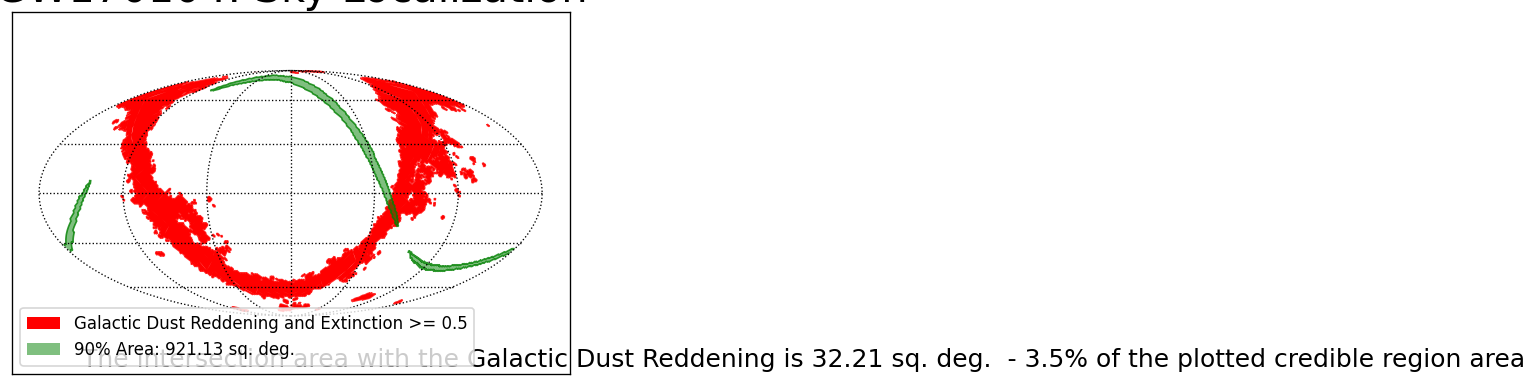

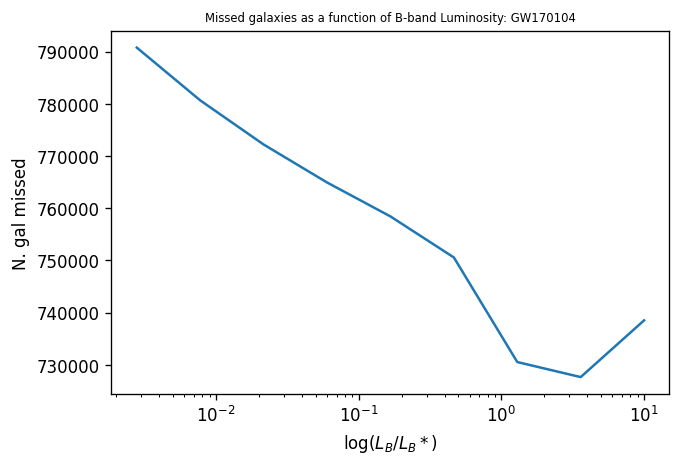

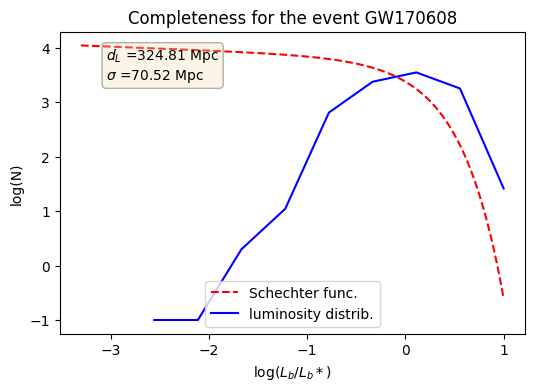

url: ///Users/mlisa/Desktop/tesi_completezza_v8/run_o1_o2_o3/GW170729_multiorder.fits
/Users/mlisa/Desktop/tesi_completezza_v8
Directory 'GW170729' already exists!
name: GW170729
path: /Users/mlisa/Desktop/tesi_completezza_v8/GW170729


<Figure size 720x480 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

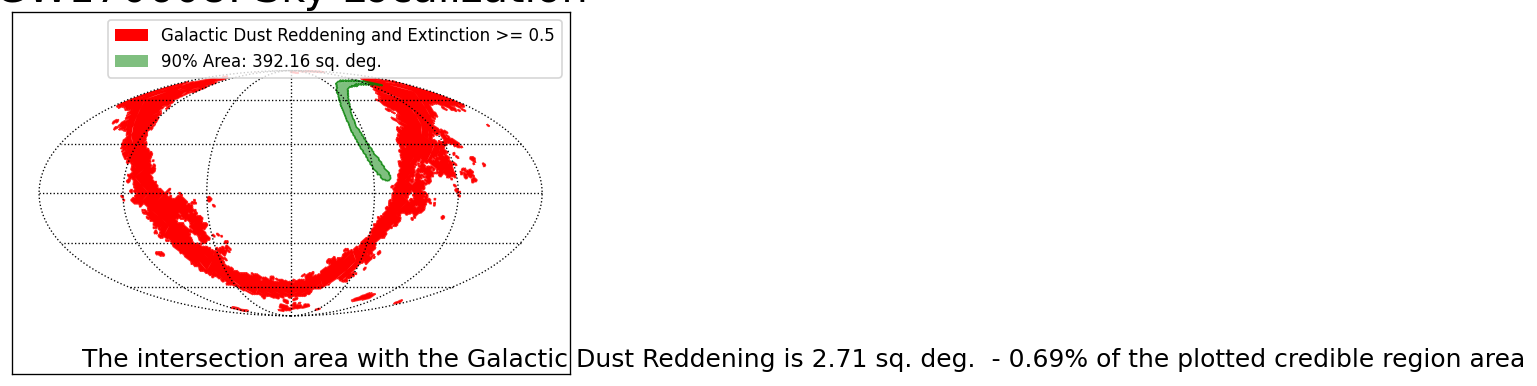

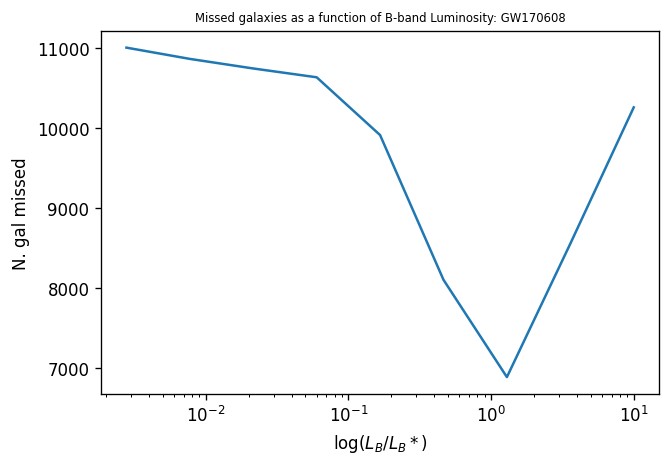

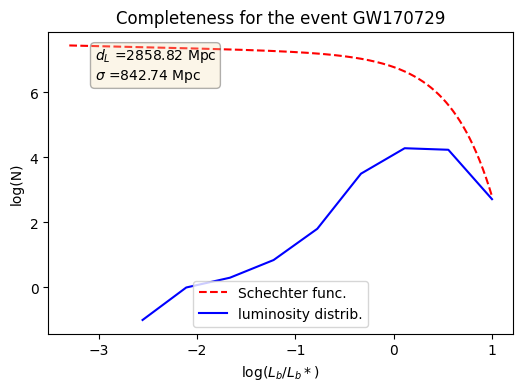

url: ///Users/mlisa/Desktop/tesi_completezza_v8/run_o1_o2_o3/GW170809_multiorder.fits
/Users/mlisa/Desktop/tesi_completezza_v8
Directory 'GW170809' already exists!
name: GW170809
path: /Users/mlisa/Desktop/tesi_completezza_v8/GW170809


<Figure size 720x480 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

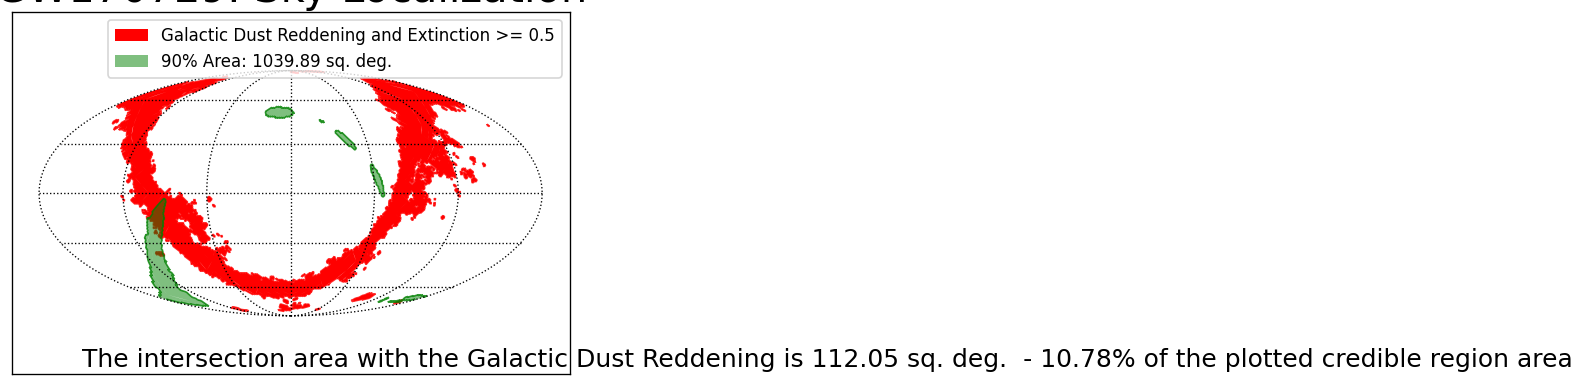

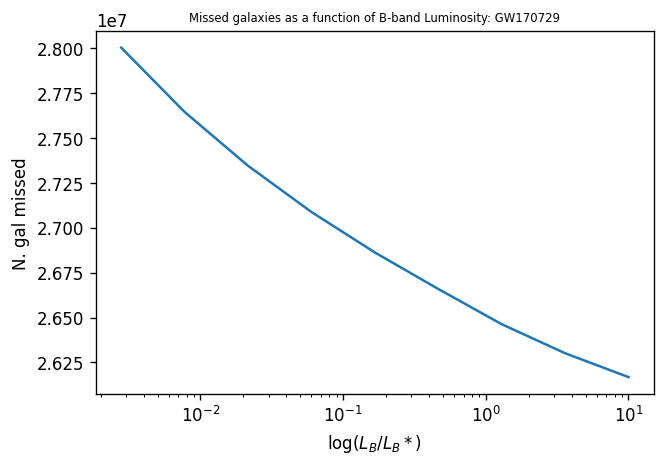

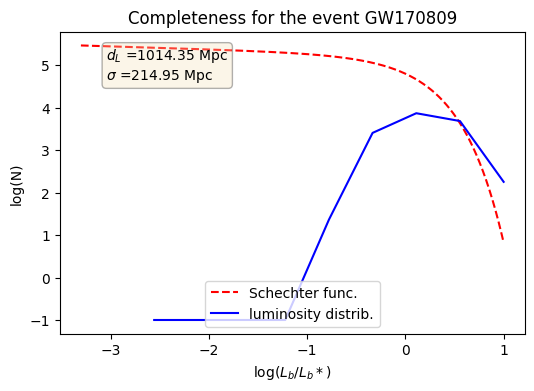

url: ///Users/mlisa/Desktop/tesi_completezza_v8/run_o1_o2_o3/GW170814_multiorder.fits
/Users/mlisa/Desktop/tesi_completezza_v8
Directory 'GW170814' already exists!
name: GW170814
path: /Users/mlisa/Desktop/tesi_completezza_v8/GW170814


<Figure size 720x480 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

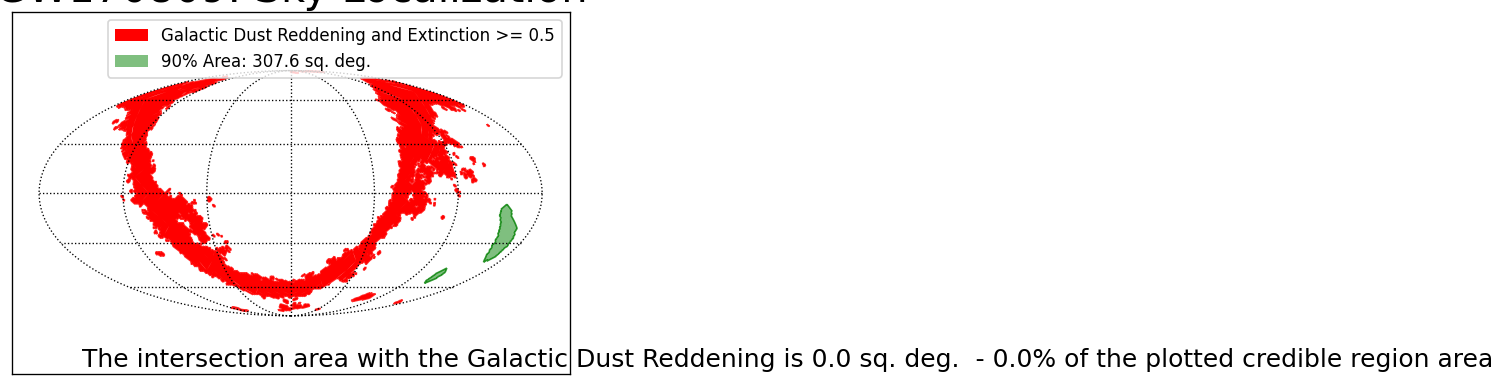

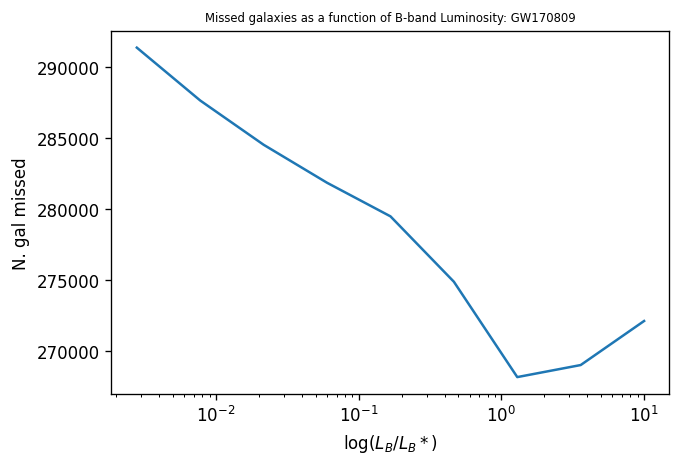

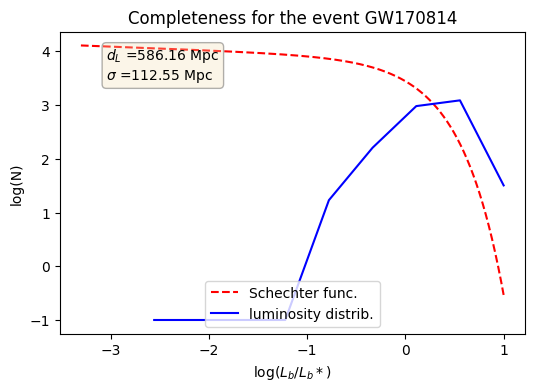

url: ///Users/mlisa/Desktop/tesi_completezza_v8/run_o1_o2_o3/GW170817_multiorder.fits
/Users/mlisa/Desktop/tesi_completezza_v8
Directory 'GW170817' already exists!
name: GW170817
path: /Users/mlisa/Desktop/tesi_completezza_v8/GW170817


<Figure size 720x480 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

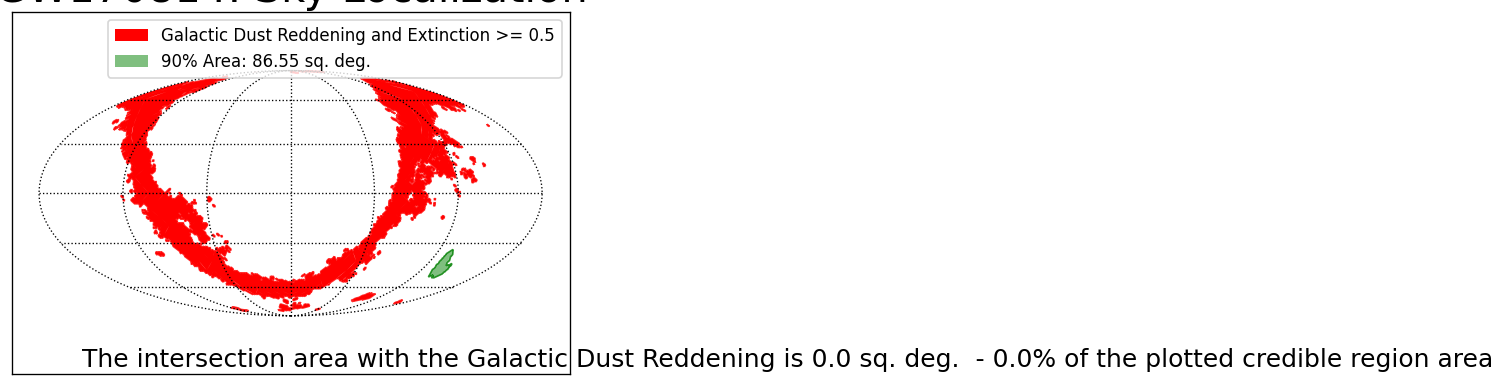

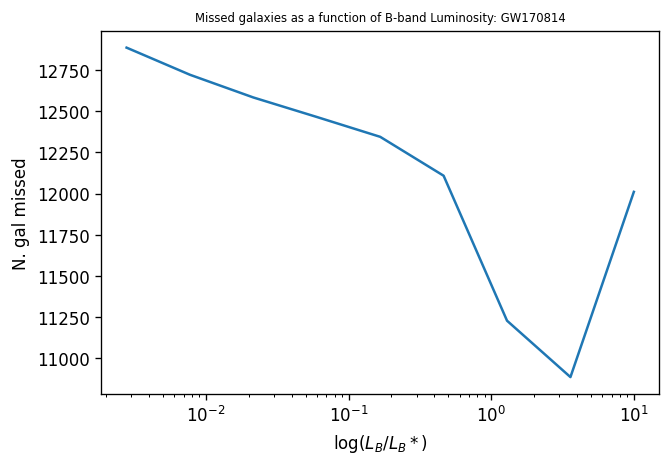

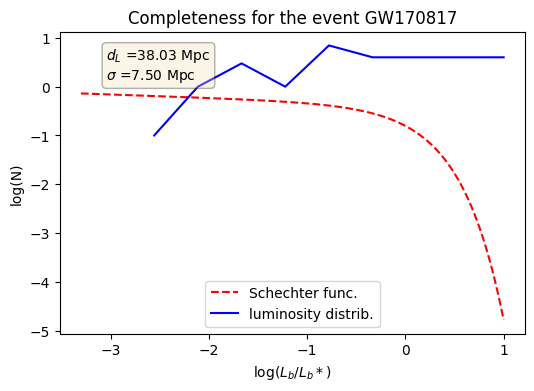

In [ ]:
%time

# Analysing O1, O2 and O3a runs.
pwd=!pwd

for name_file in sorted(os.listdir('//'+pwd[0]+'/run_o1_o2_o3')):

    if name_file.endswith("_multiorder.fits"): 
        url_evento = os.path.join('//' + pwd[0] +'/run_o1_o2_o3', name_file)
        print("url: " + url_evento)
        destination_path, name = create_directories(url_evento)
        
        print("name: " + name)
        print("path: " + destination_path)
        
        x, summa, R1,R2, m_th, distmean, catalogue_name, volume, lum_tot = \
        completeness(pwd[0]+'/run_o1_o2_o3/'+name+'_multiorder.fits',destination_path)
                    
        luminosity_from_schechter_function(volume)

        perc_int = intersection_credible_region_galactic_dust(
            pwd[0]+'/run_o1_o2_o3/'+name+'_multiorder.fits',ext_map,destination_path)
        
        miss=missed_galaxies(x, summa, volume, destination_path, catalogue_name)
        coeff_compl= coeff_completeness(lum_tot, volume)
            
        name_table.append(catalogue_name)

        dst_table.append(distmean)
        m_table.append(m_th)
        coeff_table.append(coeff_compl)
        int_perc_table.append(perc_int)
        volumes_table.append(volume)
    
    else:
        print("unknown skymap: "+ name_file)
        
print('O1, O2 and O3 Run analized!')              

In [19]:
coeff_norm=normalization(coeff_table)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
summary_table(name_table, dst_table, m_table,int_perc_table,volumes_table,coeff_norm)

\begin{tabular}{rlrrrrr}
\hline
   N° & GW event        &   Dist [Mpc] &   \$m\_\{th\}\$[magn] &   Intersection[\%]  &   V[\$Mpc\^{}\{3\}\$] &       c [\%] \\
\hline
    1 & GW150914        &          436 &            17.11 &               7.55 &        3.5e+06 & 0.0770434   \\
    2 & GW151012        &         1073 &            17.78 &              18.75 &        5.8e+08 & 0.00709128  \\
    3 & GW151226        &          445 &            17.32 &              14.63 &        2.4e+07 & 0.0597349   \\
    4 & GW170104        &          989 &            18.02 &               3.5  &        2.5e+08 & 0.00969962  \\
    5 & GW170608        &          325 &            17.4  &               0.69 &        3.4e+06 & 0.098963    \\
    6 & GW170729        &         2859 &            18.02 &              10.78 &        8.7e+09 & 0.00032362  \\
    7 & GW170809        &         1014 &            18.69 &               0    &        9.1e+07 & 0.00926876  \\
    8 & GW170814        &          586 &   

## Scatter plots

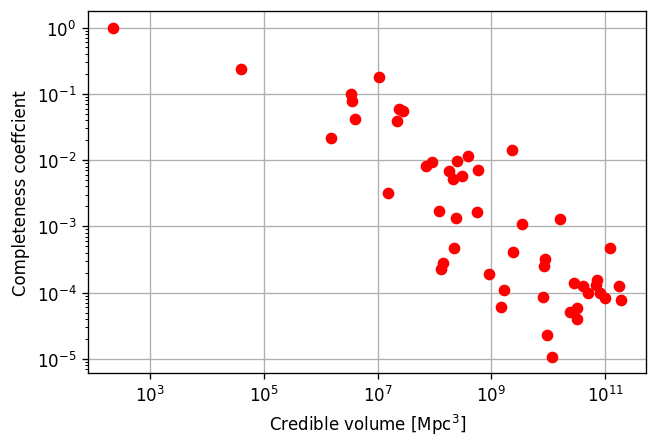

In [21]:
fig= plt.figure(dpi=120)

plt.plot(volumes_table,coeff_norm,'ro' )
plt.xlabel('Credible volume [Mpc$^3$]')
plt.ylabel('Completeness coeffcient')

plt.xscale("log")
plt.yscale("log")


plt.grid()
plt.show()

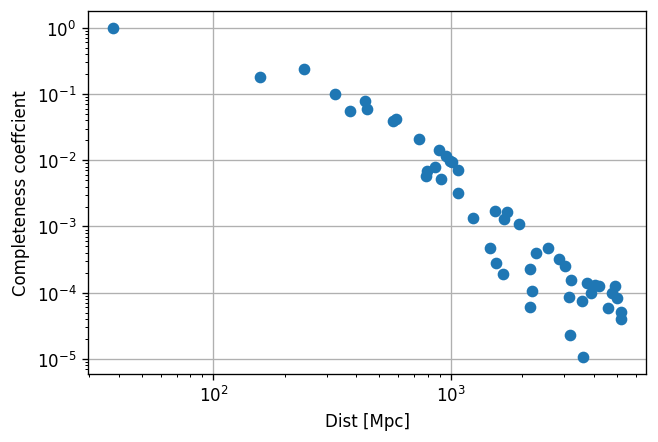

In [22]:
fig= plt.figure(dpi=120)
plt.plot(dst_table, coeff_norm, 'o' )

plt.xlabel('Dist [Mpc]')
plt.ylabel('Completeness coeffcient')

plt.xscale("log")
plt.yscale("log")

plt.grid()
plt.show()